In [17]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [18]:
# download given population dataset
pop_path = 'https://raw.githubusercontent.com/dri3s/poptemp/main/Population%20Data.csv'
pop_raw = pd.read_csv(pop_path)
pop_raw.columns = pop_raw.columns.str.lower()
pop_raw['key'] = 1

In [19]:
# download given weather dataset
wx_path = 'https://raw.githubusercontent.com/dri3s/poptemp/main/Temperature%20Data.csv'
wx_raw = pd.read_csv(wx_path)

In [20]:
# download third party airport code dataset
# extract latitude and longitude
airport_path = 'https://raw.githubusercontent.com/dri3s/poptemp/main/airport-codes_csv.csv'
airports = pd.read_csv(airport_path)
airports = airports.rename(columns={'ident':'station_code'})

airports[['lon','lat']] = airports.coordinates.str.split(',', expand=True)
airports = airports[['station_code','name','lat','lon']]
airports['lat'] = pd.to_numeric(airports.lat)
airports['lon'] = pd.to_numeric(airports.lon)

In [21]:
# create a dataframe of expected dates
wx_raw = wx_raw.rename(columns={'name':'city','location_date':'date'})
wx_raw['date'] = pd.to_datetime(wx_raw['date'])
dates = wx_raw.drop_duplicates(subset=['date'])[['date']]
dates['key'] = 1

In [22]:
# create a dataframe of expected weather stations
# join to the airport dataframe
# there is no weather data at all for KCQT, and KBUR is closeby - just drop it
locs = wx_raw.drop_duplicates(subset=['city','station_code'])[['city','station_code']]
locs = locs.loc[locs.station_code != 'KCQT'] 
locs = locs.merge(airports, how='left')
locs['key'] = 1

In [23]:
# clean the weather data
# combine expected dates and stations to make a shell
# we fill the shell with the data we have (left join)
# then, use linear interpolation method to fill missing values
# mark the values that were filled
wx = dates.merge(locs)[['date','station_code']]
wx = wx.merge(wx_raw[['station_code','date','temp_mean_c','temp_min_c','temp_max_c']], how='left')
wx = wx.sort_values(by=['station_code','date'])
wxfill = wx.groupby('station_code').apply(lambda x: x.interpolate())
wxfill.columns = [c.replace('temp','fill') for c in wxfill.columns]
wx = wx.merge(wxfill)
tempcols = [c for c in wx.columns if 'temp' in c]

for c in tempcols:    
    wx[c + '_miss'] = wx[c].isna() * 1        
    wx[c] = wx[c].fillna(wx[c.replace('temp','fill')])

wx = wx.drop(columns=[c for c in wx.columns if 'fill' in c])

In [24]:
# map the population dataset to weather station locations
# tricksy: there are duplicated city names (Aurora, IL - Aurora CO)
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    
    
    Stolen from here: 
        https://stackoverflow.com/questions/29545704/fast-haversine-approximation-python-pandas
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

popfind = pop_raw.merge(locs, on='key')
popfind['d'] = haversine_np(popfind.lon_x, popfind.lat_x, popfind.lon_y, popfind.lat_y)
pop = popfind.sort_values(by=['city_x','state','d']).groupby(['city_x','state']).first().reset_index()
pop = pop.rename(columns={'city_x':'city'})[['city','state','population','station_code','d']]

In [26]:
# matched cities/stations must be within 1000km
# this will drop HI/AK - OK, since small population
# 1000km is already a huge distance, but making it any smaller would exclude all of FL
pop = pop.loc[pop['d'] < 1000]

In [76]:
# join population and weather
# take population weighted averages
out = wx.merge(pop)

for c in tempcols:
    out[c] *= out['population']

out = out.groupby('date').sum().reset_index()

for c in tempcols:
    out[c] /= out['population']

out = out.drop(columns=['population','d'])

In [79]:
pd.DataFrame(out.loc[(out.doy >= (365 - 45 - d)) | (out.doy <= 45 - d)][tempcols].describe()

SyntaxError: unexpected EOF while parsing (<ipython-input-79-9e9ba1708c58>, line 1)

In [82]:
# graphs

# graph 1: temperature compared to seasonal avg, high, low
# assume 90 rolling seasons

out['doy'] = out.date.dt.dayofyear

def seasonal_doy(d):
    if d <= 45:
        outdoy =  pd.DataFrame(out.loc[(out.doy >= (365 - 45 - d)) | (out.doy <= 45 - d)][tempcols].describe()).loc[['mean','min','max']]
    
    elif d >= 365 - 45:
        outdoy =  pd.DataFrame(out.loc[(out.doy >= d - 45) | (out.doy <= 365 - d)][tempcols].describe()).loc[['mean','min','max']]

    else:
        outdoy =  pd.DataFrame(out.loc[out.doy.between(d - 45, d + 45)][tempcols].describe()).loc[['mean','min','max']]
        
    outdoy = outdoy.reset_index()
    outdoy = pd.melt(outdoy, id_vars='index')
    outdoy['key'] = outdoy['index'] + outdoy['variable']
    outdoy = pd.pivot_table(outdoy, columns='key', values='value').reset_index(drop=True)
    outdoy['doy'] = d
    return outdoy    

seasonal = pd.concat(seasonal_doy(d) for d in range(1, 367))                               

In [86]:
out = out.merge(seasonal)

In [89]:
out.columns

Index(['date', 'temp_mean_c', 'temp_min_c', 'temp_max_c', 'temp_mean_c_miss',
       'temp_min_c_miss', 'temp_max_c_miss', 'doy', 'maxtemp_max_c',
       'maxtemp_mean_c', 'maxtemp_min_c', 'meantemp_max_c', 'meantemp_mean_c',
       'meantemp_min_c', 'mintemp_max_c', 'mintemp_mean_c', 'mintemp_min_c'],
      dtype='object')

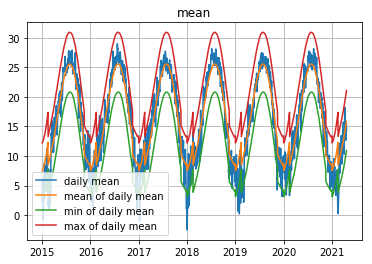

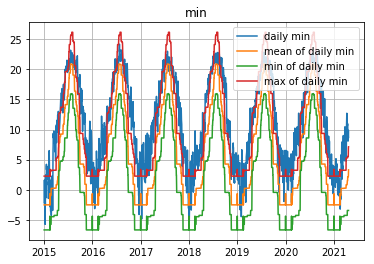

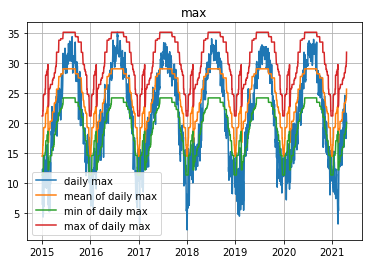

In [92]:
out = out.sort_values(by='date')

for typ in ['mean','min','max']:
    fig, ax = plt.subplots()
    ax.plot(out['date'], out['temp_{}_c'.format(typ)], label='daily {}'.format(typ))
    
    for aggtyp in ['mean','min','max']:
        ax.plot(out['date'], out['{}temp_{}_c'.format(typ, aggtyp)], label='{} of daily {}'.format(aggtyp, typ))
    ax.grid()
    ax.legend()
    ax.set_title(typ)

Text(0.5,1,'Monthly mean/min/max')

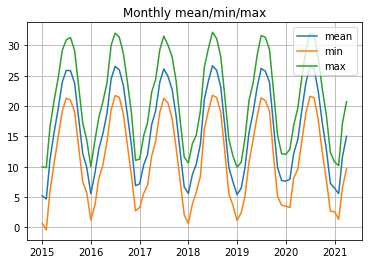

In [93]:
# graph 2: monthly average, min, max
out['ym'] = out['date'] - pd.to_timedelta(out.date.dt.day - 1, 'd')

monthly = out.groupby('ym')[tempcols].mean().reset_index()

fig, ax = plt.subplots()
for c in tempcols:
    ax.plot(monthly.ym, monthly[c], label=c.replace('temp_','').replace('_c',''))
ax.grid()
ax.legend()
ax.set_title('Monthly mean/min/max')

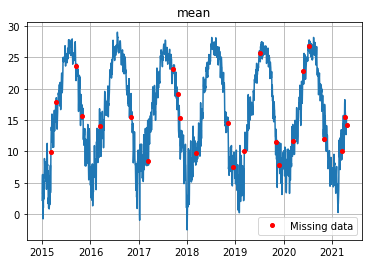

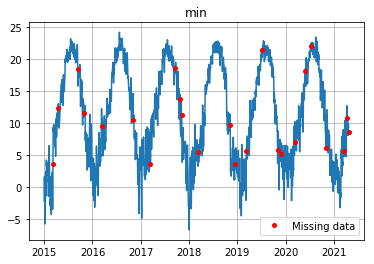

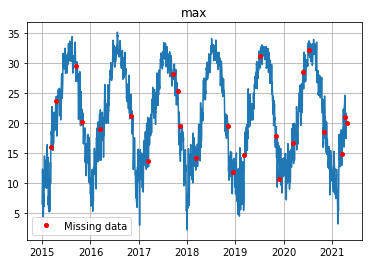

In [94]:
# graph 3: time series showing projected data
for c in tempcols:
    fig, ax = plt.subplots()
    ax.plot(out.date, out[c], label='_nolabel_')
    missg = out.loc[out[c + '_miss'] > 0]
    ax.plot(missg.date, missg[c], color='r', linestyle='None', markersize = 4, marker='o', label='Missing data')
    ax.grid()
    ax.legend()
    ax.set_title(c.replace('temp_','').replace('_c',''))